# Classificação de armas por waveform (áudio bruto)

Treinamento com **waveform** (1D) em vez de mel-espectrograma, usando **1D CNN** e **data augmentation** para buscar resultado melhor que o baseline (~62%).  
Dataset: [Gunshot Audio Dataset](https://www.kaggle.com/datasets/emrahaydemr/gunshot-audio-dataset).

## Imports e configuração

In [ ]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import librosa
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, BatchNormalization, Dense, Dropout, GlobalAveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Parâmetros de áudio (mesmos do notebook principal)
SAMPLE_RATE = 22050
DURATION = 2.0
SAMPLES_FIXOS = int(SAMPLE_RATE * DURATION)  # 44100

## Carregar lista de arquivos e rótulos

In [4]:
def criar_dataframe_arquivos(diretorio_base):
    lista_arquivos = []
    for label in os.listdir(diretorio_base):
        path_classe = os.path.join(diretorio_base, label)
        if os.path.isdir(path_classe):
            for nome_arquivo in os.listdir(path_classe):
                if nome_arquivo.lower().endswith(('.wav', '.mp3')):
                    path_completo = os.path.join(path_classe, nome_arquivo)
                    lista_arquivos.append({'filepath': path_completo, 'label': label})
    return pd.DataFrame(lista_arquivos)

path = Path("data")
df_audios = criar_dataframe_arquivos(path)
X = df_audios['filepath'].values
y = df_audios['label'].values
print(f"Total: {len(X)} amostras, {len(np.unique(y))} classes")

Total: 851 amostras, 9 classes


## Split treino / validação / teste

15,00 % teste
15,00 % validação
70,00 % treino


In [ ]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.176, random_state=42, stratify=y_train_val
)
print(f"Treino: {len(X_train)}, Val: {len(X_val)}, Teste: {len(X_test)}")

Treino: 595, Val: 128, Teste: 128


## Carregar waveform (com data augmentation no treino)

Cada áudio vira um vetor de tamanho fixo `SAMPLES_FIXOS`. No treino aplicamos **ruído gaussiano** e **deslocamento no tempo** para melhor generalização.

In [6]:
def carregar_waveform(filepath, augmentar=False, ruido_std=0.005, max_shift=2205):
    """Carrega áudio, fixa tamanho e opcionalmente aplica augmentation (ruído + shift)."""
    y, sr = librosa.load(filepath, sr=SAMPLE_RATE, mono=True, duration=DURATION)
    if len(y) < SAMPLES_FIXOS:
        y = librosa.util.fix_length(y, size=SAMPLES_FIXOS)
    else:
        y = y[:SAMPLES_FIXOS]
    if augmentar:
        y = y + ruido_std * np.random.randn(len(y))
        shift = np.random.randint(-max_shift, max_shift + 1)
        y = np.roll(y, shift)
    # Normalização por amostra (zero mean, unit std) para treino estável
    y = (y - np.mean(y)) / (np.std(y) + 1e-8)
    return y.astype(np.float32)

In [7]:
print("Carregando waveforms de TREINO (com augmentation, 2x para mais diversidade)...")
X_train_wav_1 = np.array([carregar_waveform(f, augmentar=True) for f in tqdm(X_train)])
X_train_wav_2 = np.array([carregar_waveform(f, augmentar=True) for f in tqdm(X_train)])
X_train_wav = np.concatenate([X_train_wav_1, X_train_wav_2], axis=0)
del X_train_wav_1, X_train_wav_2
print("Carregando waveforms de VALIDAÇÃO...")
X_val_wav = np.array([carregar_waveform(f, augmentar=False) for f in tqdm(X_val)])
print("Carregando waveforms de TESTE...")
X_test_wav = np.array([carregar_waveform(f, augmentar=False) for f in tqdm(X_test)])

# Formato (N, SAMPLES_FIXOS, 1) para Conv1D
X_train_wav = X_train_wav[..., np.newaxis]
X_val_wav = X_val_wav[..., np.newaxis]
X_test_wav = X_test_wav[..., np.newaxis]
print(f"Shape treino: {X_train_wav.shape}")

Carregando waveforms de TREINO (com augmentation, 2x para mais diversidade)...


  0%|          | 0/595 [00:00<?, ?it/s]c:\Users\Everton Kauan\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 595/595 [00:01<00:00, 314.06it/s]


Carregando waveforms de VALIDAÇÃO...


100%|██████████| 128/128 [00:02<00:00, 56.46it/s]


Carregando waveforms de TESTE...


100%|██████████| 128/128 [00:02<00:00, 53.12it/s]

Shape treino: (1190, 44100, 1)


In [8]:
le = LabelEncoder()
y_train_num = le.fit_transform(y_train)
y_train_num = np.tile(y_train_num, 2)  # duplicado: 2x amostras de augmentation
y_val_num = le.transform(y_val)
y_test_num = le.transform(y_test)
nomes_classes = le.classes_
NUM_CLASSES = len(nomes_classes)
print("Classes:", list(nomes_classes))
print(f"Rótulos treino (após 2x aug): {len(y_train_num)}")

Classes: ['AK-12', 'AK-47', 'IMI Desert Eagle', 'M16', 'M249', 'M4', 'MG-42', 'MP5', 'Zastava M92']
Rótulos treino (após 2x aug): 1190


## Modelo: 1D CNN na waveform

Convoluções 1D com **strides** reduzem o comprimento temporal rapidamente (eficiente). BatchNorm (normaliza afim de treino mais estável) e Dropout (menor overfitting) ajudam a generalizar.

In [9]:
model = Sequential([
    Conv1D(64, 80, strides=4, activation='relu', input_shape=(SAMPLES_FIXOS, 1), padding='same'),
    BatchNormalization(),
    MaxPooling1D(4),
    Conv1D(128, 16, strides=2, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling1D(4),
    Conv1D(256, 8, strides=2, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling1D(4),
    Conv1D(256, 4, activation='relu', padding='same'),
    BatchNormalization(),
    GlobalAveragePooling1D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

c:\Users\Everton Kauan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 11025, 64)      │         5,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 11025, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 2756, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 1378, 128)      │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1378, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 344, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 172, 256)       │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 172, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 43, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 43, 256)        │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 43, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 698,057 (2.66 MB)

 Trainable params: 696,649 (2.66 MB)

 Non-trainable params: 1,408 (5.50 KB)

## Treinamento

In [10]:
early = EarlyStopping(
    monitor='val_loss', patience=15, restore_best_weights=True, verbose=1
)
checkpoint = ModelCheckpoint(
    'melhor_modelo_waveform.keras', monitor='val_accuracy', save_best_only=True, verbose=1
)

history = model.fit(
    X_train_wav, y_train_num,
    validation_data=(X_val_wav, y_val_num),
    epochs=100,
    batch_size=32,
    callbacks=[early, checkpoint],
    verbose=1
)

Epoch 1/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step - accuracy: 0.3668 - loss: 1.7723
Epoch 1: val_accuracy improved from None to 0.36719, saving model to melhor_modelo_waveform.keras

Epoch 1: finished saving model to melhor_modelo_waveform.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 22s 507ms/step - accuracy: 0.4487 - loss: 1.5283 - val_accuracy: 0.3672 - val_loss: 1.8297
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - accuracy: 0.6361 - loss: 1.0297
Epoch 2: val_accuracy did not improve from 0.36719
38/38 ━━━━━━━━━━━━━━━━━━━━ 19s 489ms/step - accuracy: 0.6336 - loss: 1.0116 - val_accuracy: 0.2188 - val_loss: 2.3344
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step - accuracy: 0.6690 - loss: 0.9072
Epoch 3: val_accuracy did not improve from 0.36719
38/38 ━━━━━━━━━━━━━━━━━━━━ 19s 497ms/step - accuracy: 0.7092 - loss: 0.8192 - val_accuracy: 0.1406 - val_loss: 3.5803
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step - accuracy: 0.7494 - loss: 0.6645
Epoch 4: val_accuracy did not impr

## Curvas de treino

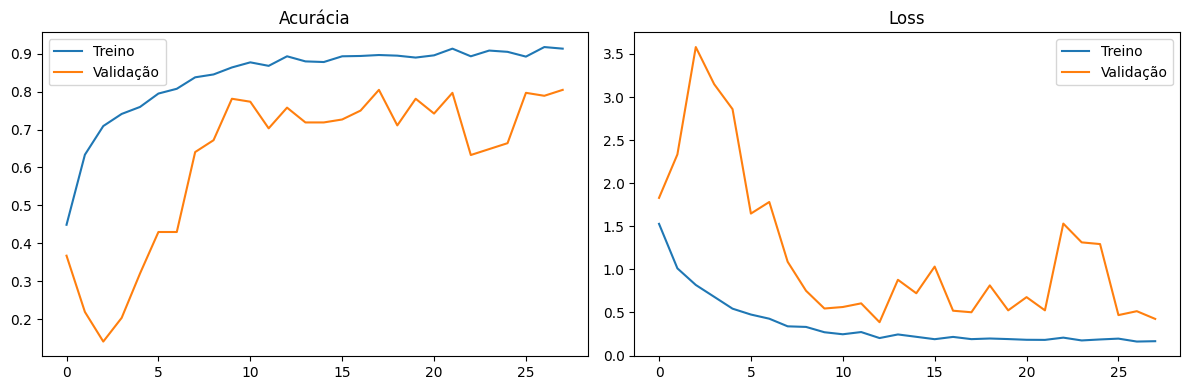

In [11]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title('Acurácia')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Loss')
plt.legend()
plt.tight_layout()
plt.show()

## Avaliação no conjunto de teste

In [12]:
y_pred_probs = model.predict(X_test_wav)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

print("--- Relatório de Classificação ---\n")
print(classification_report(y_test_num, y_pred_classes, target_names=nomes_classes))
print("\nAcurácia no teste:", np.mean(y_pred_classes == y_test_num))

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step
--- Relatório de Classificação ---

                  precision    recall  f1-score   support

           AK-12       1.00      1.00      1.00        15
           AK-47       1.00      0.91      0.95        11
IMI Desert Eagle       1.00      0.87      0.93        15
             M16       0.24      0.33      0.28        15
            M249       1.00      0.73      0.85        15
              M4       0.15      0.13      0.14        15
           MG-42       1.00      0.93      0.97        15
             MP5       0.78      0.93      0.85        15
     Zastava M92       0.92      1.00      0.96        12

        accuracy                           0.75       128
       macro avg       0.79      0.76      0.77       128
    weighted avg       0.78      0.75      0.76       128


Acurácia no teste: 0.75


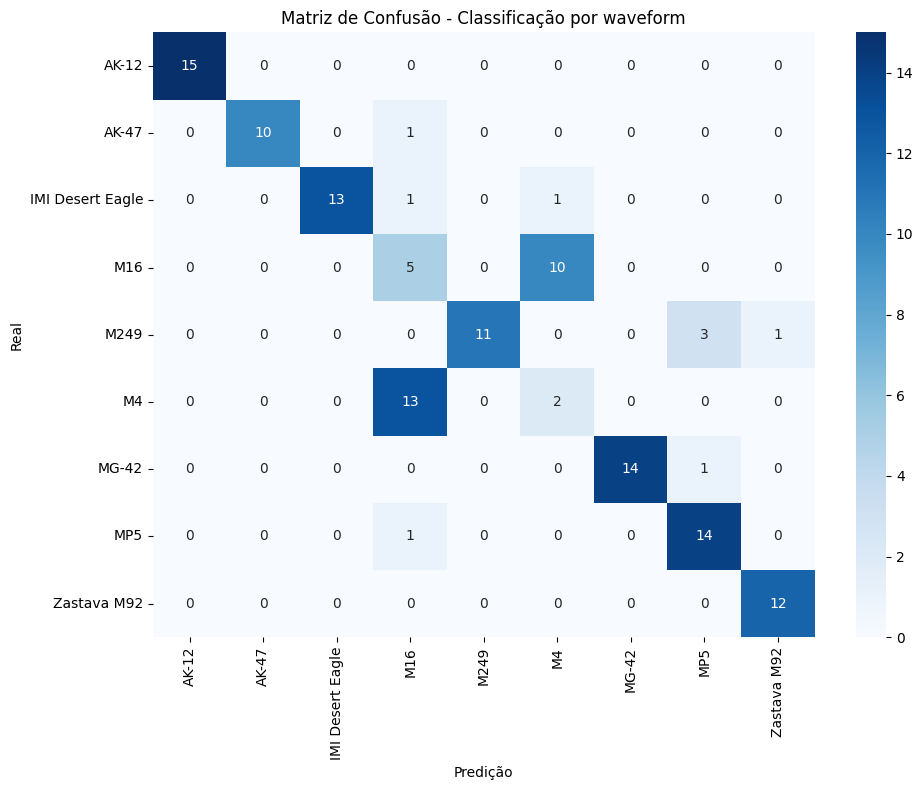

In [13]:
fig, ax = plt.subplots(figsize=(10, 8))
cm = confusion_matrix(y_test_num, y_pred_classes)
sns.heatmap(cm, xticklabels=nomes_classes, yticklabels=nomes_classes, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Predição')
ax.set_ylabel('Real')
ax.set_title('Matriz de Confusão - Classificação por waveform')
plt.tight_layout()
plt.show()

In [15]:
# Se a acurácia no teste for maior que o baseline (~0.62), salve o modelo:
model.save('modelo_classificacao_armas_waveform.keras')